# Runkeeper cardio activities analysis

In [10]:
#Import packages
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from nltk.corpus import stopwords
from datetime import datetime


#Change working directory
os.getcwd()


'C:\\Users\\E082499\\Documents\\Udacity Data Scientist Nanodegree\\Project 1 Blog post\\Project1'

# Import data and explore datasets

## 1) Cardio activities

## 2) MN temperature

## 3) WI temperature

In [11]:
def read_in_datasets(filename):
    
    '''
    INPUT
    filename - filename to input
    
    OUTPUT
    dataframe
    '''
    
    df=pd.read_csv(filename)
    
    print(df.info())
    print('\n',df.head())
    
    return df


In [12]:
# 1) Cardio activities

cardio=read_in_datasets('.\data\cardioActivities.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Id               437 non-null    object 
 1   Date                      437 non-null    object 
 2   Type                      437 non-null    object 
 3   Route Name                1 non-null      object 
 4   Distance (mi)             437 non-null    float64
 5   Duration                  437 non-null    object 
 6   Average Pace              437 non-null    object 
 7   Average Speed (mph)       437 non-null    float64
 8   Calories Burned           437 non-null    float64
 9   Climb (ft)                437 non-null    int64  
 10  Average Heart Rate (bpm)  33 non-null     float64
 11  Friend's Tagged           2 non-null      object 
 12  Notes                     97 non-null     object 
 13  GPX File                  421 non-null    object 
dtypes: float64

In [13]:
# 2) MN temperature
temp_mn=read_in_datasets('.\data\minneapolis_st_paul_weather_data.csv')

print('\nOldest date is: '+temp_mn['Date'].min())
print('Newest date is: '+temp_mn['Date'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4436 entries, 0 to 4435
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date                             4436 non-null   object 
 1   Maximum Temperature degrees (F)  4436 non-null   float64
 2   Minimum Temperature degrees (F)  4436 non-null   float64
 3   Precipitation (inches)           4436 non-null   object 
 4   Snow (inches)                    4436 non-null   object 
 5   Snow Depth (inches)              4436 non-null   object 
dtypes: float64(2), object(4)
memory usage: 208.1+ KB
None

          Date  Maximum Temperature degrees (F)  \
0  2010-01-01                              6.0   
1  2010-01-02                              1.0   
2  2010-01-03                              7.0   
3  2010-01-04                              7.0   
4  2010-01-05                             10.0   

   Minimum Temperature degrees (F) P

In [14]:
# 3) WI temperature
temp_wi=read_in_datasets('.\data\madison_wi_temp.csv')

print('\nOldest date is: '+temp_wi['sampledate'].min())
print('Newest date is: '+temp_wi['sampledate'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55151 entries, 0 to 55150
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sampledate             55151 non-null  object 
 1   year                   55151 non-null  int64  
 2   ave_air_temp_adjusted  55151 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB
None

    sampledate  year  ave_air_temp_adjusted
0  1870-06-05  1870                   20.0
1  1870-06-06  1870                   18.3
2  1870-06-07  1870                   17.5
3  1870-06-09  1870                   13.3
4  1870-06-10  1870                   13.9

Oldest date is: 1869-01-01
Newest date is: 2019-12-31


# Data understanding and preparation/cleaning steps

## Cardio activities
- GPX File is just a string and provides no value
- Though average heart rate is missing from 92% of the data, keep it to validate the measurements 
- The Walking, Hiking, and Rowing activities combined take up less than 2% of the data, so focus just on Running and Cycling
- Extract the month and year from the date and the time of day (am/pm) from the time
- Remove anything less than 1 mile, there are several times I mention cool down in the notes and these short distances should really have been recorded as Walking
- To break activities down over time, lets add month, year, and season
- Delete columns with 99% or more of missing data


## MN weather
- The MN weather dataframe has precipitation columns that are not needed and will be dropped.  
- The temperature range is from 2010-2022 which covers the dates where the activities occured in MN (2011-2012 and 2017 and later).  
- Additionally, the date is an object and is in ISO 8601 format (YYYY-MM-DD). 
- Finally, the assumption is that the run was likely done during the maximum temperature of the day

## WI weather
- The WI weather has a year column that is redundant with the date column.  
- Similarly to the MN weather, the dates are in ISO 8601 format.  
- To be consistent with the MN weather, change the sampledate column to Date.  
- In contrast to the MN weather data, the temperature readings go back as far as 1869.  However, joining the weather to the cardio activities will remove most of the extra data.  
- Finally, need to convert to degrees Fahrenheit to be consistent with the MN weather.




In [15]:
# Cardio activities preparation

# Drop columns that had more than the threshold percent of missing values
threshold=98

mis=pd.DataFrame(round(cardio.isna().sum()/len(cardio)*100,1).reset_index())
mis.columns=['name','pct']

too_many_nans=mis.loc[mis['pct']>=threshold,'name'].to_list()
cardio.drop(columns=too_many_nans,inplace=True)

print('Columns removed due to excess missing values:')
print(too_many_nans)

# Drop GPX File column
cardio.drop(columns=['GPX File'],inplace=True)

# Dates and time of day
cardio['datetime']=pd.to_datetime(cardio['Date'])
cardio['Date']=pd.to_datetime(cardio['datetime'].dt.date)
cardio['time']=cardio['datetime'].dt.time
cardio.loc[cardio['datetime'].dt.hour<12,'am_pm']='am'
cardio.loc[cardio['am_pm'].isnull(),'am_pm']='pm'

# Keep Running and Cycling 
print('\nActivity type percentage')
print(round(cardio['Type'].value_counts(normalize=True)*100,1))

cardio=cardio.loc[cardio['Type'].isin(['Running','Cycling']).copy()]

# Removing short distances
cardio=cardio.loc[cardio['Distance (mi)']>1]

# Adding month, year, and season
cardio['month']=cardio['Date'].dt.month
cardio['year']=cardio['Date'].dt.year
cardio['month_year']=cardio['year'].astype(str)+ '_' + cardio['month'].astype(str)+'_1'
cardio['month_year']=pd.to_datetime(cardio['month_year'],format='%Y_%m_%d')


cardio['season']=''
cardio.loc[cardio['month']<=3,'season']='winter'
cardio.loc[(cardio['month']>3) & (cardio['month']<=6),'season']='spring'
cardio.loc[(cardio['month']>6) & (cardio['month']<=9),'season']='summer'
cardio.loc[cardio['month']>9,'season']='fall'

Columns removed due to excess missing values:
['Route Name', "Friend's Tagged"]

Activity type percentage
Running    74.8
Cycling    23.6
Walking     1.1
Hiking      0.2
Rowing      0.2
Name: Type, dtype: float64


In [16]:
# MN temperature preparation

# Convert to numeric
for col in ['Maximum Temperature degrees (F)',
            'Minimum Temperature degrees (F)']:
    temp_mn[col]=pd.to_numeric(temp_mn[col],errors='coerce')
    
# Rename column so the temperature is associated with the MN location
temp_mn.rename(columns={'Maximum Temperature degrees (F)':'T_mn'},inplace=True)

# Remove redundant columns
temp_mn=temp_mn[['Date','T_mn']].copy()

# Convert the date to a datetime 
temp_mn['Date']=pd.to_datetime(temp_mn['Date'])

temp_mn.head()

,Date,T_mn
0,2010-01-01,6.0
1,2010-01-02,1.0
2,2010-01-03,7.0
3,2010-01-04,7.0
4,2010-01-05,10.0


In [17]:
# WI temperaature preparation

#Convert to degrees F
temp_wi=temp_wi.assign(T_wi=lambda x: round(x.ave_air_temp_adjusted*9/5+32,0))

# Remove redundant columns
temp_wi.drop(columns=['ave_air_temp_adjusted','year'],inplace=True)

# Rename column so the date is the same as the MN temp dataframe
temp_wi.rename(columns={'sampledate':'Date'},inplace=True)

# Convert the date to a datetime 
temp_wi['Date']=pd.to_datetime(temp_wi['Date'])

temp_wi.head()

,Date,T_wi
0,1870-06-05,68.0
1,1870-06-06,65.0
2,1870-06-07,64.0
3,1870-06-09,56.0
4,1870-06-10,57.0


# Data preparation - joins
The purpose of the join is to obtain the approximate temperature for each actvitiy.  The analysis only needs temperatures on days with activities, so a left join to the cardio activities is warranted.  

The temperature column can be created using a combination of the MN and WI temperatures.  Between Sept. 2012 - Aug. 2017, the activities were mainly in Madison, WI.  All other activities before and after that timeframe should be from Minneapolis/St. Paul, MN data.

In [18]:
# Join temperature data to the activity dataset 
cardio=pd.merge(cardio,temp_mn,how='left',on=['Date'],validate='many_to_one')
cardio=pd.merge(cardio,temp_wi,how='left',on=['Date'],validate='many_to_one')

In [19]:
# Convert the location-based temperature columns to a single temperature column
def get_temp(date_col,mn_temp,wi_temp):
    
    '''
    INPUT
    date_col - Column name containing the date
    mn_temp  - Column name containing the MN temperature 
    wi_temp  - Column name containing the WI temperature
    
    OUTPUT
    temp - A single value for temperature
    
    Perform to obtain a single column of temperature for later analysis
    '''
    
    if np.isnan(mn_temp)==True and np.isnan(wi_temp)==True:
        
        temp=np.nan
        
    else:
    
        if datetime(2012,9,1)<date_col<datetime(2017,8,15):
            temp=wi_temp
        else:
            temp=mn_temp
        
    return temp

cardio['Temp']=cardio.apply(lambda row: get_temp(row['Date'],row['T_mn'],row['T_wi']),axis=1)

# Now we can remove the other temperature columns
cardio.drop(columns=['T_mn','T_wi'],inplace=True)

# Lets look at the results
print(cardio.columns)

print('\nAre there any null temperature values?')
print(cardio['Temp'].isna().any())

Index(['Activity Id', 'Date', 'Type', 'Distance (mi)', 'Duration',
       'Average Pace', 'Average Speed (mph)', 'Calories Burned', 'Climb (ft)',
       'Average Heart Rate (bpm)', 'Notes', 'datetime', 'time', 'am_pm',
       'month', 'year', 'month_year', 'season', 'Temp'],
      dtype='object')

Are there any null temperature values?
False


# Data join validation result
In several of the notes, I made brief comments about the heat.  Pull keywords from the notes column associated with the heat and verify the temperature matches the comment.

There are several times that the words hot, humid, and heat pop up in the Notes.  Subset the activities on the Notes that contain those keywords and lets look at the temperature.

In [20]:
# Isolate notes
notes=cardio.loc[cardio['Notes'].notnull(),['Notes']]

# Remove stop words
stop_words=stopwords.words('english')

def remove_stop_words(text):
    '''
    INPUT
    text - a string 
    
    OUTPUT
    text - a list containing all the words with stop words removed
    
    The function removes stop words from the note
    '''
    
    # Removing the stop words and applying lower case
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    
    
    return " ".join(text)

notes['Notes_no_stop']=notes['Notes'].apply(remove_stop_words)

word_list=' '.join([row for row in notes['Notes_no_stop']]).split()

word_df=pd.DataFrame(word_list,columns=['words'])

word_df_counts=pd.DataFrame(word_df['words'].value_counts().reset_index())
word_df_counts=word_df_counts.loc[word_df_counts['words']>1]
word_df_counts.columns=['word','count']

print('Word count in Notes','\n',word_df_counts.head(25))

Word count in Notes 
            word  count
0       outside     17
1          felt     16
2          left     15
3   compressors     13
4         first     11
5          quad     10
6           day      7
7          days      7
8      ultimate      7
9             ,      7
10         ride      7
11            j      6
12          hot      6
13         bike      6
14       little      6
15           j,      6
16         mile      5
17          ran      5
18          run      5
19            .      5
20         good      5
21        humid      5
22        right      5
23         legs      4
24        chest      4


In [21]:
hot_words=['hot','humid','heat']

high_temps=cardio.loc[cardio['Notes'].str.contains('|'.join(hot_words),na=False),['Date','Temp']]

print(high_temps.sort_values(by='Date'))

          Date  Temp
145 2019-09-30  86.0
101 2020-07-07  88.0
90  2020-08-14  85.0
88  2020-08-17  78.0
85  2020-08-25  90.0
34  2021-05-24  87.0
32  2021-06-05  99.0
21  2021-07-18  88.0


Result of join validation: Yes, these look like hot temperatures (for the Midwest that is!).

# Summary statistics and additional data preparation of running and biking data
- Separate running from biking
- Look at the summary statistics for both


In [22]:
# Running summary statistics
run=cardio.loc[cardio['Type']=='Running'].copy()

run_stats=run.describe()

print('Running summary statistics')
print(run_stats)


Running summary statistics
       Distance (mi)  Average Speed (mph)  Calories Burned   Climb (ft)  \
count     299.000000           299.000000       299.000000   299.000000   
mean        3.047559             6.975017       317.122637   169.167224   
std         1.077003             0.853619       115.583947   214.471753   
min         1.020000             3.850000       101.000000     0.000000   
25%         2.300000             6.515000       239.000000    68.500000   
50%         3.050000             7.080000       318.000000   105.000000   
75%         3.510000             7.575000       369.500000   177.500000   
max         8.150000            10.280000       845.000000  1571.000000   

       Average Heart Rate (bpm)       month         year        Temp  
count                 24.000000  299.000000   299.000000  299.000000  
mean                 164.750000    7.317726  2017.287625   65.384615  
std                   16.616519    2.426653     2.841013   14.327283  
min          

### Running data summary statistics and findings
- I have not run more than 10 miles when recording, so the max distance of 8.15 miles checks out.
- A max average speed of 10 mph makes sense.  For us non-Olympians, try sustaining that pace on a treadmill!
- Maximum heart rate is 220 - your age [Source](https://www.polar.com/blog/calculate-maximum-heart-rate-running/).
    - This was over 10 years, so the absolute maximum should not be higher than 190.  The max is 185 bpm, so that checks out!
- I can handle the cold, but my cutoff is usually around 20 degrees F.  A min of 24 F checks out!

In [23]:
# Biking summary statistics
bike=cardio.loc[cardio['Type']=='Cycling'].copy()

bike_stats=bike.describe()

print('Biking summary statistics')
print(bike_stats)

Biking summary statistics
       Distance (mi)  Average Speed (mph)  Calories Burned   Climb (ft)  \
count     103.000000           103.000000       103.000000   103.000000   
mean       12.142427            13.634951       416.091679   424.873786   
std         6.101622             1.555393       227.219370   313.233193   
min         1.740000             9.060000        58.000000     0.000000   
25%         8.315000            12.725000       271.000000   242.000000   
50%        12.520000            13.860000       416.000000   373.000000   
75%        15.815000            14.585000       528.000000   545.000000   
max        45.700000            17.990000      1823.989992  2250.000000   

       Average Heart Rate (bpm)       month         year        Temp  
count                  9.000000  103.000000   103.000000  103.000000  
mean                 134.111111    6.854369  2017.300971   74.330097  
std                   17.758410    1.497762     2.789458   10.058055  
min           

### Biking data summary statistics and findings
- I have not bikied more than 50 miles when recording, so the max distance of 45.7 miles checks out.
- The maximum heart rate of 152 bpm makes sense since I'm always a little less winded after biking than running
- The temperature range between 45 and 97 makes sense, since my cutoff for biking is around 40 degrees F.  

# Analysis and results

## Was there improvement over time?
- Often these can be answered in many ways.  Let's look at several metrics over time

## Did my 5k times improve?

## What affect did the new bike have?

## What affect does time of year have on running performance? 
- This directly coincides with temperature

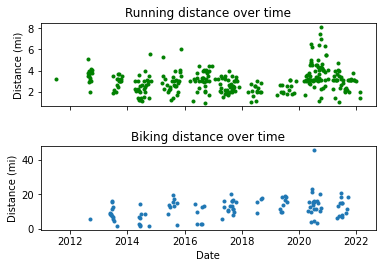

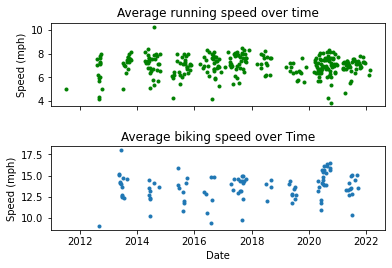

In [24]:
# Was there improvment over time?  
#Distance over time for running and biking
fig, ax = plt.subplots(2,1,sharex=True)
fig.tight_layout(pad=3)


ax[0].plot(run['Date'],run['Distance (mi)'],marker='o',linestyle='none',markersize=3,color='green')
ax[0].set_title('Running distance over time')
ax[0].set_ylabel('Distance (mi)')

ax[1].plot(bike['Date'],bike['Distance (mi)'],marker='o',linestyle='none',markersize=3)
ax[1].set_title('Biking distance over time')
ax[1].set_ylabel('Distance (mi)')
ax[1].set_xlabel('Date')

plt.show()


#Average speed over time for running and biking
fig, ax = plt.subplots(2,1,sharex=True)
fig.tight_layout(pad=3)


ax[0].plot(run['Date'],run['Average Speed (mph)'],marker='o',linestyle='none',markersize=3,color='green')
ax[0].set_title('Average running speed over time')
ax[0].set_ylabel('Speed (mph)')

ax[1].plot(bike['Date'],bike['Average Speed (mph)'],marker='o',linestyle='none',markersize=3)
ax[1].set_title('Average biking speed over Time')
ax[1].set_ylabel('Speed (mph)')
ax[1].set_xlabel('Date')

plt.show()



### Biking results
For biking, there isn't a strong trend over time, but there is a more consistent higher average speed over time in 2020.  This coincided with the pandemic and more biking activities for the year similar to running.
### Running results
For running, there isn't a strong trend over time, but there are larger max distances in 2020.  This makes sense since I started running more often due to the pandemic.  Let's verify this with a count of runs per year.  


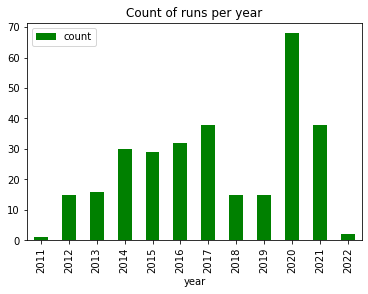

In [25]:
runs_by_year=run.groupby('year')['Date'].agg({'count'}).reset_index()

runs_by_year.plot.bar(x='year',y='count',color='green')
plt.title('Count of runs per year')
plt.show()

The increase in max distance over time is attributed to the increased overall fitness based on running more often.  The decrease in 2018 and 2019 makes sense because I started working full time in late 2017.  As expected, there was a drop in flexibility and subsequently the amount of time for runs.  This then changed with the pandemic as commute times were minimized, and more time was prioritized working out and going outside.

In [26]:
# Did 5k times improve?

# Subset for 5k distances
fiveK=run.loc[(run['Distance (mi)']>3) & (run['Distance (mi)']<3.15)]

#Look at my fastest 5ks each year
fiveK_agg=fiveK.groupby(['year']).agg({'Duration':'min'}).reset_index()

print(fiveK_agg)


   year Duration
0  2012    26:00
1  2013    22:21
2  2014    22:13
3  2015    23:33
4  2016    25:32
5  2018    26:02
6  2019    26:15
7  2020    22:33
8  2021    23:52


There isn't a clear trend of improving over time, however this trend matches the amount of runs per time.  In 2018-2019 when I first started working, I ran less, and my 5k times increased.  However, after the pandemic hit, I was able to run more and consequently was able to reduce my 5k times back to 2013-2014 levels.  I'd say maintaining the same 5k time in 2020-2021 compared to 2013-2014 when I was 6+ years younger is a win by itself.  

          Date
109 2020-06-20


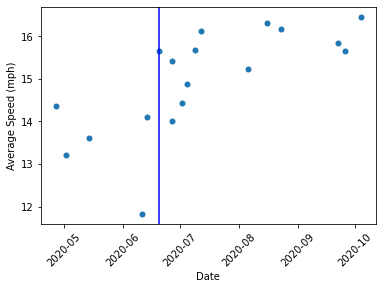

In [27]:
# What effect did the new bike have?
print(bike.loc[bike['Notes'].str.contains('new bike',na=False),['Date']])

new_bike_affect=bike.loc[(bike['year']==2020) & (bike['Distance (mi)']>=10)]

plt.plot(new_bike_affect['Date'],new_bike_affect['Average Speed (mph)'],marker='o',linestyle='none',markersize=5)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Average Speed (mph)')
plt.axvline(x = '2020-06-20', color = 'b')
plt.show()


In [28]:
indep = new_bike_affect['month']
dep = new_bike_affect['Average Speed (mph)']

# OLS regression
results = sm.OLS(dep,sm.add_constant(indep)).fit()

print('R2: ', round(results.rsquared,2))

R2:  0.45


Looking at the data above, there are some higher biking speeds and distances in 2020. Lets look at the average speed and distance within several months before and after I got the new, and slightly lighter," road bike that year.  Lets consider longer rides as well (at least 10 miles).  

Luckily, I can obtain the first date I used the new bike thanks to one of my notes.

This appears that there is a moderate correlation between the month and average speed based on when I got the new road bike.  Lets quantify that.

The 0.45 is below the typical threshold of 0.5 for a moderate strength correlation, so the new bike had a minor affect on average speed overall.  

In [29]:
# What effect does time of year have on running performance? 

#Bin the weather
run['temp_bin']=pd.cut(run['Temp'],bins=[20, 30, 40, 50, 60, 70, 80, 90, 100])

print(run.groupby('temp_bin').agg({'Average Speed (mph)':['mean','max'],
                                   'Distance (mi)':['max']}).reset_index())

# Break down by season

print('\n',run.groupby('season').agg({'Average Speed (mph)':['mean','max'],
                                 'Distance (mi)':['max','count']}).reset_index())

    temp_bin Average Speed (mph)        Distance (mi)
                            mean    max           max
0   (20, 30]            6.990000   7.69          5.45
1   (30, 40]            6.755556   7.73          6.32
2   (40, 50]            7.006250   8.11          5.31
3   (50, 60]            7.117170   8.27          6.01
4   (60, 70]            7.019383  10.28          8.15
5   (70, 80]            6.976962   8.49          6.55
6   (80, 90]            6.764687   7.99          7.46
7  (90, 100]            6.451429   7.65          6.22

    season Average Speed (mph)        Distance (mi)      
                         mean    max           max count
0    fall            7.040508   8.27          7.03    59
1  spring            6.935000   8.40          6.55    90
2  summer            6.974154  10.28          8.15   130
3  winter            6.967500   8.11          5.31    20


The metrics show the optimal temperature to run in is between 50-70 degrees, which matches with fall & summer being the seasons that show the higheste average speed and distance.  